In [3]:
# “%pip” ensures you install into the kernel’s env
%pip install SPARQLWrapper wikipedia


  Using cached SPARQLWrapper-2.0.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached wikipedia-1.4.0-py3-none-any.whl
  Using cached rdflib-7.1.4-py3-none-any.whl.metadata (11 kB)
Using cached SPARQLWrapper-2.0.0-py3-none-any.whl (28 kB)
Using cached rdflib-7.1.4-py3-none-any.whl (565 kB)

   ---------------------------------------- 0/3 [rdflib]
   ---------------------------------------- 0/3 [rdflib]
   ------------- -------------------------- 1/3 [wikipedia]
   ---------------------------------------- 3/3 [SPARQLWrapper]

Note: you may need to restart the kernel to use updated packages.


In [1]:
import time
import pandas as pd
import requests
from bs4 import BeautifulSoup
from SPARQLWrapper import SPARQLWrapper, JSON
import wikipedia
import matplotlib.pyplot as plt
import seaborn as sns

# Wikidata SPARQL endpoint
WIKIDATA_SPARQL = "https://query.wikidata.org/sparql"


In [3]:
data = {
    "company_name": [
        "Airbnb",
        "Stripe",
        "NonExistent Co"
    ],
    "company_url": [
        "https://www.airbnb.com",
        "https://stripe.com",
        "https://example.com/nonexistent"
    ]
}
df_raw = pd.DataFrame(data)
df_raw


,company_name,company_url
0,Airbnb,https://www.airbnb.com
1,Stripe,https://stripe.com
2,NonExistent Co,https://example.com/nonexistent


In [5]:
def fetch_meta_description(url):
    try:
        r = requests.get(url, timeout=5)
        soup = BeautifulSoup(r.text, "html.parser")
        tag = soup.find("meta", {"name": "description"})
        return tag["content"].strip() if tag else None
    except:
        return None

df_raw["meta_desc"] = df_raw["company_url"].map(fetch_meta_description)
df_raw


,company_name,company_url,meta_desc
0,Airbnb,https://www.airbnb.com,Get an Airbnb for every kind of trip → 7 milli...
1,Stripe,https://stripe.com,Stripe is a suite of APIs powering online paym...
2,NonExistent Co,https://example.com/nonexistent,None


In [7]:
def enrich_from_wikidata(name):
    sparql = SPARQLWrapper(WIKIDATA_SPARQL)
    sparql.setQuery(f'''
      SELECT ?industryLabel ?employees WHERE {{
        ?item rdfs:label "{name}"@en.
        ?item wdt:P31/wdt:P279* wd:Q4830453.
        OPTIONAL {{ ?item wdt:P452 ?industry.
                   ?industry rdfs:label ?industryLabel.
                   FILTER(LANG(?industryLabel)="en") }}
        OPTIONAL {{ ?item wdt:P1128 ?employees. }}
      }} LIMIT 1
    ''')
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()["results"]["bindings"]
    if not results:
        return {"industry": None, "employees": None}
    row = results[0]
    return {
        "industry": row.get("industryLabel", {}).get("value"),
        "employees": int(row["employees"]["value"]) if "employees" in row else None
    }

# Apply enrichment
enriched = [enrich_from_wikidata(n) for n in df_raw["company_name"]]
df_wd = pd.concat([df_raw, pd.DataFrame(enriched)], axis=1)
df_wd


,company_name,company_url,meta_desc,industry,employees
0,Airbnb,https://www.airbnb.com,Get an Airbnb for every kind of trip → 7 milli...,tourism industry,5597.0
1,Stripe,https://stripe.com,Stripe is a suite of APIs powering online paym...,mobile payment industry,2500.0
2,NonExistent Co,https://example.com/nonexistent,None,None,NaN


In [9]:
def get_wiki_summary(name):
    try:
        # Try direct lookup
        page = wikipedia.page(name, auto_suggest=False)
    except (wikipedia.DisambiguationError) as e:
        page = wikipedia.page(e.options[0], auto_suggest=False)
    except (wikipedia.PageError):
        # If no exact page, search and pick top result
        results = wikipedia.search(name)
        if not results:
            return None
        try:
            page = wikipedia.page(results[0], auto_suggest=False)
        except:
            return None
    except:
        return None

    # Throttle  to avoid API bans
    time.sleep(0.5)
    # Return first sentence
    return page.summary.split("\n")[0]

# Apply summaries
df_wd["wiki_summary"] = df_wd["company_name"].map(get_wiki_summary)
df_wd


C:\Users\tejas\anaconda3\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\tejas\anaconda3\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


,company_name,company_url,meta_desc,industry,employees,wiki_summary
0,Airbnb,https://www.airbnb.com,Get an Airbnb for every kind of trip → 7 milli...,tourism industry,5597.0,"Airbnb, Inc. ( AIR-BEE-en-BEE, an abbreviation..."
1,Stripe,https://stripe.com,Stripe is a suite of APIs powering online paym...,mobile payment industry,2500.0,A stripe is a line or band that differs in col...
2,NonExistent Co,https://example.com/nonexistent,None,None,NaN,Several non-standard dates are used in calenda...


In [11]:
df_enriched = df_wd[[
    "company_name",
    "company_url",
    "industry",
    "employees",
    "meta_desc",
    "wiki_summary"
]].copy()
df_enriched


,company_name,company_url,industry,employees,meta_desc,wiki_summary
0,Airbnb,https://www.airbnb.com,tourism industry,5597.0,Get an Airbnb for every kind of trip → 7 milli...,"Airbnb, Inc. ( AIR-BEE-en-BEE, an abbreviation..."
1,Stripe,https://stripe.com,mobile payment industry,2500.0,Stripe is a suite of APIs powering online paym...,A stripe is a line or band that differs in col...
2,NonExistent Co,https://example.com/nonexistent,None,NaN,None,Several non-standard dates are used in calenda...


In [13]:
TARGET_INDUSTRY = "Software"
EMP_MIN, EMP_MAX = 50, 500
KEYWORDS = {
    "marketplace": 3,
    "payment": 2,
    "financial": 2,
    "cloud": 2,
    "ai": 2
}

def score_lead(row):
    s = 0
    # Industry match
    if row.industry and TARGET_INDUSTRY.lower() in row.industry.lower():
        s += 2
    # Employee count
    if row.employees and EMP_MIN <= row.employees <= EMP_MAX:
        s += 1
    # Keyword hits in both descriptions
    text = " ".join(filter(None, [row.meta_desc, row.wiki_summary])).lower()
    for kw, w in KEYWORDS.items():
        if kw in text:
            s += w
    return min(s * 10, 100)

df_enriched["score"] = df_enriched.apply(score_lead, axis=1)
df_enriched.sort_values("score", ascending=False, inplace=True)
df_enriched


,company_name,company_url,industry,employees,meta_desc,wiki_summary,score
0,Airbnb,https://www.airbnb.com,tourism industry,5597.0,Get an Airbnb for every kind of trip → 7 milli...,"Airbnb, Inc. ( AIR-BEE-en-BEE, an abbreviation...",50
1,Stripe,https://stripe.com,mobile payment industry,2500.0,Stripe is a suite of APIs powering online paym...,A stripe is a line or band that differs in col...,40
2,NonExistent Co,https://example.com/nonexistent,None,NaN,None,Several non-standard dates are used in calenda...,0


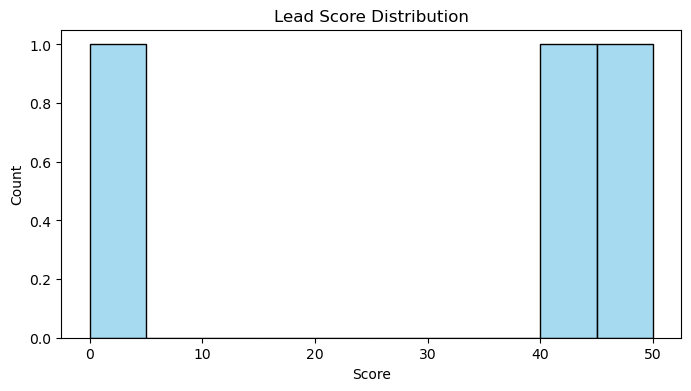

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(df_enriched["score"], bins=10, color="skyblue")
plt.title("Lead Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()


In [17]:
df_enriched.to_csv("enriched_scored_leads.csv", index=False)
print("✅ Saved enriched_scored_leads.csv")


✅ Saved enriched_scored_leads.csv


In [19]:
from bs4 import BeautifulSoup
def extract_roles(html):
    soup = BeautifulSoup(html, "html.parser")
    return [tag.text for tag in soup.select(".org-people-profile-card__title")]


In [23]:
# Assuming df_raw exists from earlier steps
url_list = df_raw["company_url"].dropna().tolist()
len(url_list), url_list[:5]


(3,
 ['https://www.airbnb.com',
  'https://stripe.com',
  'https://example.com/nonexistent'])

In [25]:
import requests
from bs4 import BeautifulSoup

def scrape_company(url):
    """Fetch meta description for a company page."""
    try:
        r = requests.get(url, timeout=5)
        r.raise_for_status()
        soup = BeautifulSoup(r.text, "html.parser")
        tag = soup.find("meta", {"name": "description"})
        desc = tag["content"].strip() if tag else None
        return {"company_url": url, "meta_desc": desc}
    except Exception as e:
        return {"company_url": url, "meta_desc": None}


In [27]:
from concurrent.futures import ThreadPoolExecutor, as_completed

results = []
# You can adjust max_workers based on your CPU / network
with ThreadPoolExecutor(max_workers=5) as executor:
    future_to_url = {executor.submit(scrape_company, url): url for url in url_list}
    for future in as_completed(future_to_url):
        res = future.result()
        results.append(res)

# Convert back into a DataFrame
df_meta = pd.DataFrame(results)
df_meta.head()


,company_url,meta_desc
0,https://www.airbnb.com,Get an Airbnb for every kind of trip → 7 milli...
1,https://example.com/nonexistent,None
2,https://stripe.com,Stripe is a suite of APIs powering online paym...


In [29]:
df_raw = df_raw.merge(df_meta, on="company_url", how="left")
df_raw.head()


,company_name,company_url,meta_desc_x,meta_desc_y
0,Airbnb,https://www.airbnb.com,Get an Airbnb for every kind of trip → 7 milli...,Get an Airbnb for every kind of trip → 7 milli...
1,Stripe,https://stripe.com,Stripe is a suite of APIs powering online paym...,Stripe is a suite of APIs powering online paym...
2,NonExistent Co,https://example.com/nonexistent,None,None


In [31]:
df_enriched["domain"] = df_enriched.company_url.str.extract(r'https?://([^/]+)')
df_enriched.drop_duplicates("domain", inplace=True)


In [37]:
from IPython.display import HTML, display

display(HTML('<span style="color:white; background-color:green; '
             'padding:2px 5px; border-radius:4px; font-weight:bold;">'
             '80</span>'))


In [39]:
from IPython.display import HTML, display

html_badge = """
<span style="
    color: white;
    background-color: green;
    padding: 2px 5px;
    border-radius: 4px;
    font-weight: bold;
">
  80
</span>
"""
display(HTML(html_badge))


In [41]:
from IPython.display import HTML, display

html_badge = '''
<span style="
    color: white;
    background-color: green;
    padding: 2px 5px;
    border-radius: 4px;
    font-weight: bold;">
  80
</span>
'''
display(HTML(html_badge))


In [43]:
def badge_style(val):
    # choose color based on value
    if val >= 80:
        bg = "green"
    elif val >= 50:
        bg = "orange"
    else:
        bg = "red"
    return f"background-color: {bg}; color: white; font-weight: bold;"

(df_enriched
   .style
   .applymap(badge_style, subset=["score"])
   .set_properties(**{"text-align": "center"}))


C:\Users\tejas\AppData\Local\Temp\ipykernel_22456\447240126.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(badge_style, subset=["score"])


,company_name,company_url,industry,employees,meta_desc,wiki_summary,score,domain
0,Airbnb,https://www.airbnb.com,tourism industry,5597.000000,Get an Airbnb for every kind of trip → 7 million holiday rentals → 2 million Guest Favourites → 220+ countries and regions worldwide,"Airbnb, Inc. ( AIR-BEE-en-BEE, an abbreviation of its original name, ""Air Bed and Breakfast"") is an American company operating an online marketplace for short-and-long-term homestays, experiences and services in various countries and regions. It acts as a broker and charges a commission from each booking. Airbnb was founded in 2008 by Brian Chesky, Nathan Blecharczyk, and Joe Gebbia. It is the best-known company for short-term housing rentals.",50,www.airbnb.com
1,Stripe,https://stripe.com,mobile payment industry,2500.000000,Stripe is a suite of APIs powering online payment processing and commerce solutions for internet businesses of all sizes. Accept payments and scale faster with AI.,A stripe is a line or band that differs in color or tone from an adjacent area. Stripes are a group of such lines in a repeating pattern of similar regions.,40,stripe.com
2,NonExistent Co,https://example.com/nonexistent,None,nan,None,"Several non-standard dates are used in calendars for various purposes: some are expressly fictional, some are intended to produce a rhetorical effect (such as sarcasm), and others attempt to address a particular mathematical, scientific or accounting requirement or discrepancy within the calendar system.",0,example.com


In [1]:
# streamlit_app.py

import streamlit as st
import pandas as pd

# Optional: for AgGrid row selection  
# from st_aggrid import AgGrid, GridUpdateMode, DataReturnMode

st.set_page_config(
    page_title="LeadGen Dashboard",
    layout="wide",
    initial_sidebar_state="expanded"
)

@st.cache_data
def load_data(path="enriched_scored_leads.csv"):
    df = pd.read_csv(path)
    # Clean up columns if needed
    df["industry"] = df["industry"].fillna("Unknown")
    return df

def main():
    st.title("🚀 Enriched & Scored Leads Dashboard")
    df = load_data()

    # Sidebar filters
    st.sidebar.header("Filter Leads")

    # 1) Score threshold
    min_score = st.sidebar.slider(
        "Minimum Lead Score", 
        min_value=0, max_value=100, value=30, step=5
    )

    # 2) Industry multi-select
    industries = ["Unknown"] + sorted(df["industry"].dropna().unique().tolist())
    selected_industries = st.sidebar.multiselect(
        "Industry", industries, default=industries
    )

    # 3) Employee count range
    emp_min, emp_max = int(df["employees"].min(skipna=True)), int(df["employees"].max(skipna=True))
    emp_range = st.sidebar.slider(
        "Employee Count Range", 
        min_value=emp_min,
        max_value=emp_max,
        value=(emp_min, emp_max)
    )

    # 4) Keyword search in name or summary
    keyword = st.sidebar.text_input("Search Keyword (name/summary)")

    # Apply filters
    mask = (
        (df["score"] >= min_score) &
        (df["industry"].isin(selected_industries)) &
        (df["employees"].between(emp_range[0], emp_range[1], inclusive="both"))
    )
    filtered = df[mask].copy()

    if keyword:
        keyword_lower = keyword.lower()
        filtered = filtered[
            filtered["company_name"].str.lower().str.contains(keyword_lower) |
            filtered["wiki_summary"].str.lower().str.contains(keyword_lower, na=False)
        ]

    st.markdown(f"**Showing {len(filtered)} leads** after filters.")

    # Main table
    st.dataframe(filtered, use_container_width=True)

    # Download button
    st.download_button(
        label="📥 Download Filtered Leads as CSV",
        data=filtered.to_csv(index=False).encode("utf-8"),
        file_name="filtered_leads.csv",
        mime="text/csv"
    )

    # Detail expanders
    st.header("Lead Details")
    for idx, row in filtered.iterrows():
        with st.expander(f"{row.company_name} — Score: {int(row.score)}"):
            st.write("**URL:**", row.company_url)
            st.write("**Industry:**", row.industry)
            st.write("**Employees:**", int(row.employees) if pd.notnull(row.employees) else "Unknown")
            st.write("**Summary:**", row.wiki_summary or "N/A")
            st.write("**Meta-Description:**", row.get("meta_desc") or "N/A")

if __name__ == "__main__":
    main()


2025-07-08 12:27:21.281 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-07-08 12:27:22.272 
  command:

    streamlit run C:\Users\tejas\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-08 12:27:22.272 No runtime found, using MemoryCacheStorageManager
2025-07-08 12:27:22.322 Session state does not function when running a script without `streamlit run`
